## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [75]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [76]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [77]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [78]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [79]:
df[df['converted'] == 1]['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [80]:
df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].shape[0] +df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0]

3893

f. Do any of the rows have missing values?

In [81]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [82]:
df_1 = df.query("group == 'control' & landing_page == 'old_page'")
df_2 = df.query("group == 'treatment' & landing_page == 'new_page'")
df2 = df_1.append(df_2)

In [83]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [84]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [85]:
df2[df2['user_id'].duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [86]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [87]:
df2 = df2.drop(2893)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [88]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [89]:
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [90]:
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [91]:
df2.query("landing_page == 'new_page'").shape[0]/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**The old page have a conversion rate of 0.1204 which is pretty close to the conversion rate of the new page with 0.1188 conversion rate because this difference is under 1.5% and it seems to be unsignificant. We conclude that we don't have evidence that one page leads to more conversion**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$$H_0 : p_{new} - p_{old} <= 0 $$**
**$$H_1 : p_{new} - p_{old} > 0$$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [92]:
#Under the null hypothesis,  𝑝_𝑛𝑒𝑤  and  𝑝_𝑜𝑙𝑑  both have "true" success rates
#equal to the converted success rate regardless of page - that is  𝑝_𝑛𝑒𝑤  and  
#𝑝_𝑜𝑙𝑑  are equal. Furthermore, assume they are equal to the converted rate in 
#ab_data.csv regardless of the page. 
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [93]:
#Under the null hypothesis,  𝑝_𝑛𝑒𝑤  and  𝑝_𝑜𝑙𝑑  both have "true" success rates
#equal to the converted success rate regardless of page - that is  𝑝_𝑛𝑒𝑤  and  
#𝑝_𝑜𝑙𝑑  are equal. Furthermore, assume they are equal to the converted rate in 
#ab_data.csv regardless of the page. 
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [94]:
n_new = df2.query('group == "treatment"')['user_id'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [95]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [96]:
new_page_converted = np.random.choice((1,0), size = n_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [97]:
old_page_converted = np.random.choice((1,0), size = n_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [98]:
new_page_converted.mean() - old_page_converted.mean()


0.00056935176844276347

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [50]:
p_diffs = []
for _ in range(10000):
    old_df = np.random.choice((1,0), size = n_old, p = [p_old, 1-p_old])
    new_df = np.random.choice((1,0), size = n_new, p = [p_new, 1-p_new])
    p_old = old_df.mean()
    p_new = new_df.mean()
    p_diffs.append(p_new - p_old)
    
np.array(p_diffs)

array([ 0.00116094, -0.00052525, -0.00083501, ...,  0.04995238,
        0.05081939,  0.04911919])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [51]:
obs_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()

obs_diff

-0.0015782389853555567

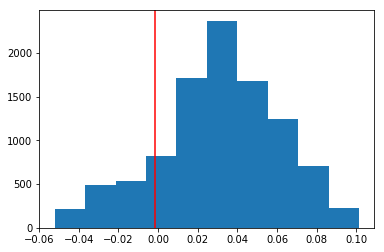

In [52]:
# plot distribution under the null hypothesis
plt.hist(p_diffs)
plt.axvline(obs_diff, color = 'red')

#### The plotted histogram looks like a normal distribution and that was expected

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [53]:
(p_diffs > obs_diff).mean()

0.86270000000000002

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We computed the p_value wich indicates the probability of finding the observed result when the null hypothesis $H_0$ is true. Although, with p_value of 0.82 > 0.05 the error rate of 5% we fail to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [54]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control' and converted == 1")['user_id'].shape[0]
convert_new = df2.query("group == 'treatment' and converted == 1")['user_id'].shape[0]
n_old = df2.query("group == 'control'")['user_id'].shape[0]
n_new = df2.query("group == 'treatment'")['user_id'].shape[0]
convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [55]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

In [56]:
#Before this test began, we would have picked a significance level. Let's just 
#say it's 95%. Since this is a test for the difference, it's a one-tail test 
#so a z-score past 1.96 will be significant.
from scipy.stats import norm

norm.cdf(z_score), norm.ppf(1-(0.05))

(0.90505831275902449, 1.6448536269514722)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z_score doesn't exeeded the significance level of 1.6448 and p_value = 0.18988 higher than error rate of 5% so we fail to reject the null hypothesis, we can say that there is no significant difference beteween the conversion of the old and the new page. The z test matches the findings in the previous parts .**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [99]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.drop('old_page', axis=1, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [100]:
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [101]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:44:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**P_value associated with ab_page is 0.19 which is different from p_value found with A/B test because their associated null and alternative hypotheses are different.**

**For A/B Test**

**$$H_0 : p_{new} - p_{old} <= 0 $$**
**$$H_1 : p_{new} - p_{old} > 0$$**

**For Logistic Regression**

**$$H_0 : p_{new} = p_{old}$$**
**$$H_1 : p_{new} \neq p_{old}$$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**In order to improve the performance of our model, we can add other factors into our regression model and make it more accurate but we should avoid multicolinearity between factors and overfitting. If we add higher terms, the interpretation of the coefficients become complicated**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [102]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [103]:
df_country['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [110]:
df_new = df2.merge(df_country, on='user_id', how='inner')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [105]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [111]:
df_new = df_new.join(pd.get_dummies(df_new['country']))
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1


In [112]:
log_md = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
result = log_md.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        10:53:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Countries p_value are greater than error rate 0.05 which means that we fail to reject the null hypothesis. Therefore, countries have no impact on the conversion rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [116]:
log_md_uk = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK']])
result_uk = log_md_uk.fit()
result_uk.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Oct 2018   Pseudo R-squ.:               1.233e-05
Time:                        11:08:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2693
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9919      0.009   -228.420      0.000      -2.009      -1.975
ab_page       -0.0150      0.011     -1.309      0.191      -0.037       0.007
UK             0.0126      0.013      0.952      0.341      -0.013       0.038
==============================================================================
"""

In [115]:
log_md_us = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US']])
result_us = log_md_us.fit()
result_us.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Oct 2018   Pseudo R-squ.:               8.152e-06
Time:                        11:08:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4201
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9877      0.012   -167.205      0.000      -2.011      -1.964
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
US            -0.0016      0.012     -0.126      0.900      -0.026       0.023
==============================================================================
"""

**As we change the country the coefficient of ab_page doesn't change, which means that there is no interaction between the two factors. Furthermore, all the p_values obtained are greater than the error rate of 5% which means that there is no statistical significance on the conversion.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])